In [1]:
! git clone https://github.com/LM1997610/Apex_detection

Cloning into 'Apex_detection'...
remote: Enumerating objects: 52, done.
remote: Counting objects: 100% (52/52), done.
remote: Compressing objects: 100% (51/51), done.
remote: Total 52 (delta 26), reused 0 (delta 0), pack-reused 0
Receiving objects: 100% (52/52), 1.90 MiB | 8.30 MiB/s, done.
Resolving deltas: 100% (26/26), done.


In [2]:
%cd /content/Apex_detection/'Faster R-CNN'

/content/Apex_detection/Faster R-CNN


## Apex Detection with RCNN

In [3]:
# ! pip -q install datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 536.7/536.7 kB 5.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 7.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 11.7 MB/s eta 0:00:00


In [4]:
import tensorflow as tf
import warnings

from datasets import load_dataset

import torch
import torchvision
from torchvision.transforms import v2 as T
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

from apex_dataload import ApexDetection

import time
from tqdm import tqdm
import matplotlib.pyplot as plt
import matplotlib.patches as patches

### Data loading

In [5]:
num_classes = 3
batch_size = 16

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [6]:
with warnings.catch_warnings():
  warnings.simplefilter("ignore")

  dataset = load_dataset(path='Francesco/apex-videogame')

Generating train split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

In [7]:
for key in dataset:

    dataset[key] = dataset[key].flatten()
    dataset[key] = dataset[key].filter(lambda example: tf.shape(example['objects.bbox'])[0] > 0)

train_d = dataset['train']
val_d = dataset['validation']
test_d = dataset['test']

Filter:   0%|          | 0/2583 [00:00<?, ? examples/s]

Filter:   0%|          | 0/415 [00:00<?, ? examples/s]

Filter:   0%|          | 0/691 [00:00<?, ? examples/s]

In [8]:
def collate_fn(batch):
    return tuple(zip(*batch))

def get_transform(train=False):
    transforms = []

    if train:
        transforms.extend([#T.RandomHorizontalFlip(0.5),
                           #T.RandomRotation(degrees=35),
                           #T.RandomResizedCrop(size=(640, 640)),
                           T.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
                           T.GaussianBlur(kernel_size=3)])

    transforms.append(T.ToDtype(torch.float, scale=True))
    transforms.append(T.ToPureTensor())

    return T.Compose(transforms)

In [9]:
train_data = ApexDetection(root = train_d, transforms = get_transform(train=True))
val_data = ApexDetection(root = val_d, transforms = get_transform(train=True))
test_data = ApexDetection(root = test_d)

data_loader_train = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
data_loader_val = torch.utils.data.DataLoader(val_data, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)

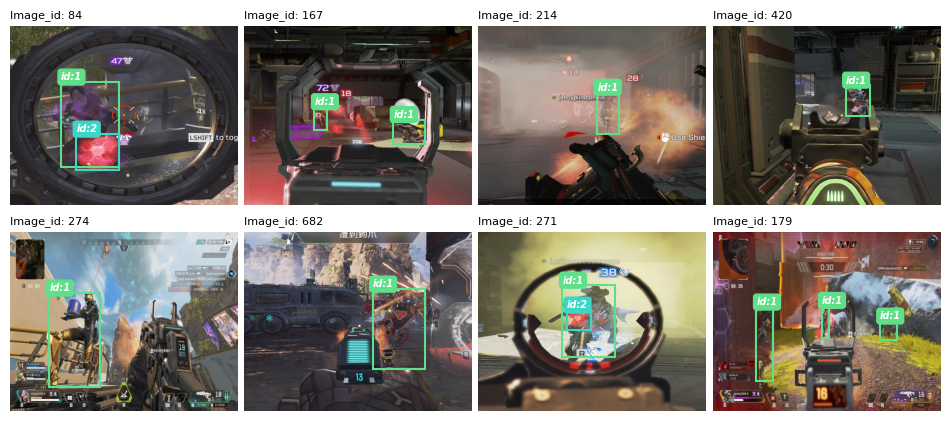

In [10]:
f, axs = plt.subplots(2, 4, sharey=True, figsize=(12, 5))
axs = axs.flatten()

imgs_index = [0, 3, 6, 8, 10, 14, 47, 572]

for i, ax in zip(imgs_index, axs):

    test_data.do_plot(i, ax=ax)

plt.subplots_adjust(wspace=0.03, hspace=0.15)
plt.show()

### Get the model

In [11]:
with warnings.catch_warnings():
  warnings.simplefilter("ignore")

  model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
model.roi_heads.detections_per_img = 10

model=model.to(device)

Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth
100%|██████████| 160M/160M [00:01<00:00, 119MB/s]


100%|██████████| 8/8 [00:47<00:00,  5.88s/it]


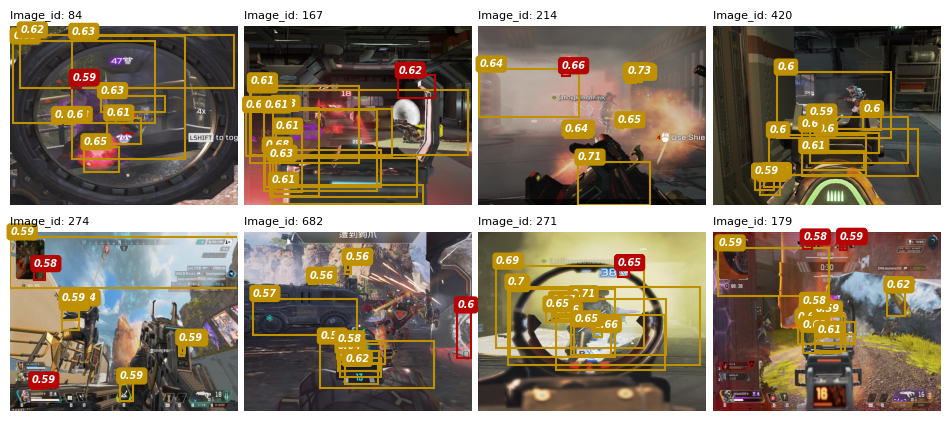

In [12]:
f, axs = plt.subplots(2, 4, sharey=True, figsize=(12, 5))
axs = axs.flatten()

imgs_index = [0, 3, 6, 8, 10, 14, 47, 572]

for i, ax in tqdm(zip(imgs_index, axs), total = len(imgs_index)):

    test_data.do_plot(i, ax=ax, model=model, treshold=0.55)

plt.subplots_adjust(wspace=0.03, hspace=0.15)
plt.show()

### Training:

In [13]:
from modules.engine import train_one_epoch, evaluate

In [14]:
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

In [ ]:
num_epochs = 10

history_train, history_val = [], []

for epoch in range(num_epochs):

    h = train_one_epoch(model, optimizer, data_loader_train, device, epoch, print_freq=100)
    lr_scheduler.step()
    history_train.append(h.meters)

    v = evaluate(model, data_loader_val, device=device)
    history_val.append(v)

# model = torch.load('the_model_v1.pt')

### Inference:

In [ ]:
! gdown 1B_e2BfbgnYFUv5Tb2_li32WnSDKSoHpY

Downloading...
From (original): https://drive.google.com/uc?id=1B_e2BfbgnYFUv5Tb2_li32WnSDKSoHpY
From (redirected): https://drive.google.com/uc?id=1B_e2BfbgnYFUv5Tb2_li32WnSDKSoHpY&confirm=t&uuid=2a8deb48-6f11-4d87-8a23-6b0809778e53
To: /content/Apex_detection/the_model_v1.pt
100% 166M/166M [00:04<00:00, 36.7MB/s]


In [ ]:
model.load_state_dict(torch.load("the_model_v1.pt", map_location=torch.device('cpu')))

<All keys matched successfully>

100%|██████████| 8/8 [00:39<00:00,  4.93s/it]


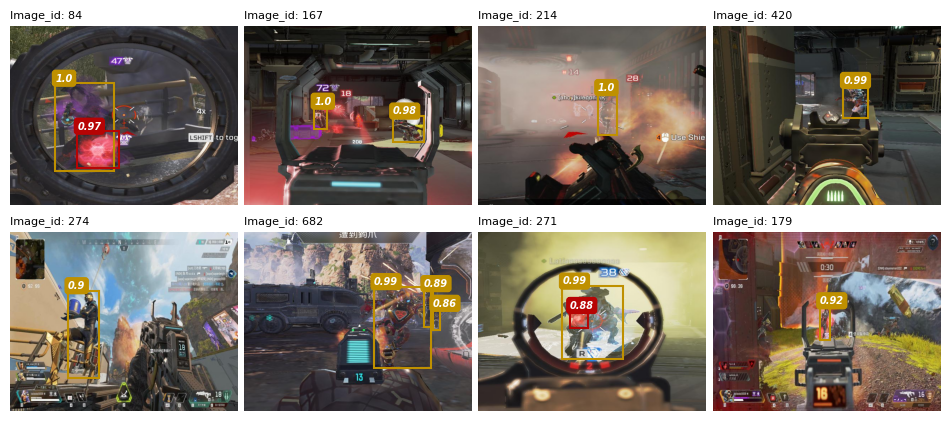

In [ ]:
f, axs = plt.subplots(2, 4, sharey=True, figsize=(12, 5))
axs = axs.flatten()

imgs_index = [0, 3, 6, 8, 10, 14, 47, 572]

for i, ax in tqdm(zip(imgs_index, axs), total = len(imgs_index)):

    test_data.do_plot(i, ax=ax, model=model, treshold=0.84)

plt.subplots_adjust(wspace=0.03, hspace=0.15)
plt.show()

In [ ]:
img, target = test_data.__getitem__(idx=3)

start_time = time.time()
boxes, labels, scores = test_data.__prediction__(img, model, threshold=0.97)

elapsed_time = time.time() - start_time

print("Time taken:", elapsed_time, "seconds")

Time taken: 5.148483991622925 seconds
